<a href="https://colab.research.google.com/github/sanaaria/Ann/blob/main/Ann_HW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
#دانلود دیتاست
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [48]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [49]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['train', 'test']
['bird', 'deer', 'ship', 'truck', 'dog', 'frog', 'automobile', 'cat', 'horse', 'airplane']


In [5]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print(len(airplane_files))
print(airplane_files[:5])

5000
['1195.png', '1823.png', '0637.png', '4659.png', '1292.png']


In [6]:
ship_test_files = os.listdir(data_dir + "/test/ship")
print(len(ship_test_files))
print(ship_test_files[:5])

1000
['0637.png', '0390.png', '0807.png', '0345.png', '0425.png']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [50]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [51]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [10]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [11]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [12]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  airplane (0)


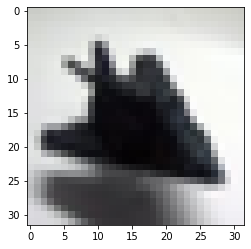

In [13]:
show_example(*dataset[0])

Label:  airplane (0)


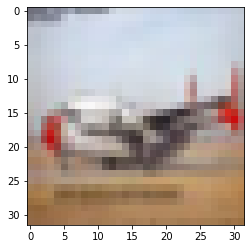

In [14]:
show_example(*dataset[1099])

In [52]:
random_seed = 42
torch.manual_seed(random_seed);

In [53]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

In [54]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

 متفاوتی به ما می دهد batch کد زیر هربار که اجرا میشود  

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

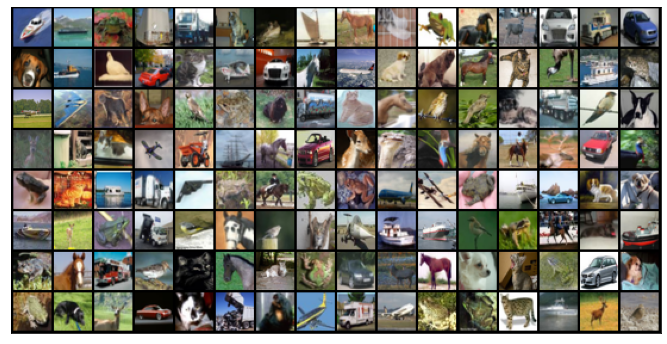

In [ ]:
show_batch(train_dl)

In [19]:
def apply_kernel(image, kernel):
    ri, ci = image.shape       # image dimensions
    rk, ck = kernel.shape      # kernel dimensions
    ro, co = ri-rk+1, ci-ck+1  # output dimensions
    output = torch.zeros([ro, co])
    for i in range(ro): 
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk,j:j+ck] * kernel)
    return output

In [20]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)
sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [25]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 0.0382,  0.0317,  0.0154, -0.0468, -0.0217,  0.0371, -0.0408, -0.0377,
        -0.0310,  0.0118], grad_fn=<SelectBackward0>)


In [32]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [34]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(Cifar10CnnModel(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.302245855331421, 'val_acc': 0.10039062798023224}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7438, val_loss: 1.3929, val_acc: 0.4829
Epoch [1], train_loss: 1.2258, val_loss: 1.1006, val_acc: 0.5946
Epoch [2], train_loss: 0.9778, val_loss: 0.9627, val_acc: 0.6517
Epoch [3], train_loss: 0.8028, val_loss: 0.8390, val_acc: 0.7127
Epoch [4], train_loss: 0.6647, val_loss: 0.7607, val_acc: 0.7381
Epoch [5], train_loss: 0.5435, val_loss: 0.7478, val_acc: 0.7553
Epoch [6], train_loss: 0.4329, val_loss: 0.7165, val_acc: 0.7691
Epoch [7], train_loss: 0.3384, val_loss: 0.7847, val_acc: 0.7613
Epoch [8], train_loss: 0.2592, val_loss: 0.8553, val_acc: 0.7648
Epoch [9], train_loss: 0.1932, val_loss: 0.9297, val_acc: 0.7630


In [40]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

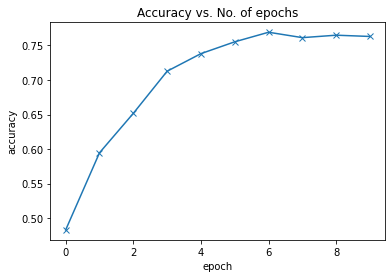

In [ ]:
plot_accuracies(history)

In [41]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

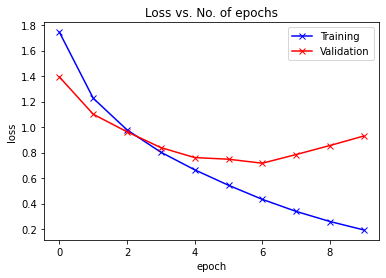

In [ ]:
plot_losses(history)

استفاده میکنیم  dropoutهمانطور که مشاهده میشود دچار اورفیت شدیم برای حل ان از

البته میتوان فقط تعداد اپوک هارو کاهش داده و 3 برسانیم

In [ ]:
class Cifar10CnnModelwithdropout(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.5),   

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Dropout(0.5),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModelwithdropout()
model

Cifar10CnnModelwithdropout(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Dropout(p=0.5, inplace=False)
    (18): Flatten(

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
model = to_device(Cifar10CnnModelwithdropout(), device)

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_loss': 2.3031792640686035, 'val_acc': 0.09523207694292068}

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8350, val_loss: 1.5079, val_acc: 0.4246
Epoch [1], train_loss: 1.3861, val_loss: 1.2847, val_acc: 0.5275
Epoch [2], train_loss: 1.1969, val_loss: 1.0512, val_acc: 0.6163
Epoch [3], train_loss: 1.0848, val_loss: 1.0753, val_acc: 0.6089
Epoch [4], train_loss: 0.9902, val_loss: 0.8806, val_acc: 0.6816
Epoch [5], train_loss: 0.9131, val_loss: 0.8320, val_acc: 0.7040
Epoch [6], train_loss: 0.8525, val_loss: 0.9162, val_acc: 0.6753
Epoch [7], train_loss: 0.8079, val_loss: 0.7931, val_acc: 0.7232
Epoch [8], train_loss: 0.7683, val_loss: 0.7277, val_acc: 0.7441
Epoch [9], train_loss: 0.7291, val_loss: 0.7258, val_acc: 0.7555


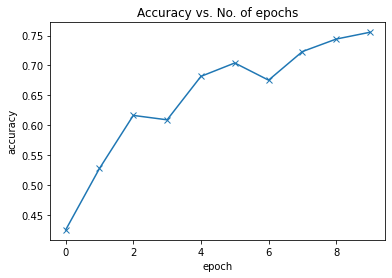

In [ ]:
plot_accuracies(history)

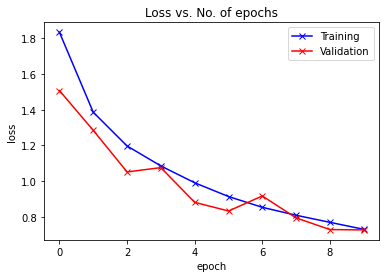

In [ ]:
plot_losses(history)

همانطور که مشاهده میشود دقت این مدل روی ولید 75 درصد میباشد
حال روی داده های تست هم امتحانشون میکنیم تا دقت نهایی رو به دست بیاوریم

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


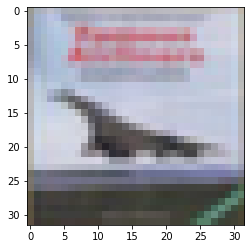

In [ ]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: automobile


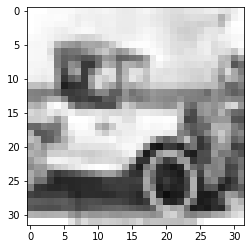

In [ ]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: frog


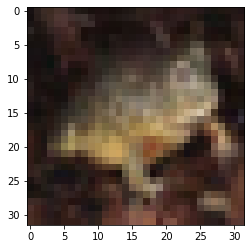

In [ ]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.7119386196136475, 'val_acc': 0.75732421875}

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [ ]:
model2 = to_device(Cifar10CnnModelwithdropout(), device)

In [ ]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [ ]:
evaluate(model2, test_loader)

{'val_loss': 0.7119386196136475, 'val_acc': 0.75732421875}

در نتیجه دقت این مدل در مجموعه تست نیز 75 درصد میباشد

حال مدل را با تعداد لایه های متفاوت بررسی میکنیم

برای مثال مدل را با 4 لایه کانولوشنالی بررسی میکنیم

In [ ]:
class Cifar10CnnModel4layers(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.5),   

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Dropout(0.5),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel4layers()
model

Cifar10CnnModel4layers(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inplace=False)
    (16): Flatten(start_dim=1, end_dim=-1)
    (17): Linear(in_features=4096, out_features=1024, bias=True)
    (18):

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
model = to_device(Cifar10CnnModel4layers(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.303316593170166, 'val_acc': 0.09523207694292068}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.8462, val_loss: 1.4475, val_acc: 0.4602
Epoch [1], train_loss: 1.3849, val_loss: 1.1912, val_acc: 0.5689
Epoch [2], train_loss: 1.2124, val_loss: 1.1453, val_acc: 0.5849
Epoch [3], train_loss: 1.1109, val_loss: 1.0003, val_acc: 0.6442
Epoch [4], train_loss: 1.0357, val_loss: 0.9925, val_acc: 0.6481
Epoch [5], train_loss: 0.9731, val_loss: 0.8773, val_acc: 0.6943
Epoch [6], train_loss: 0.9138, val_loss: 0.8398, val_acc: 0.7050
Epoch [7], train_loss: 0.8589, val_loss: 0.8104, val_acc: 0.7145
Epoch [8], train_loss: 0.8147, val_loss: 0.7470, val_acc: 0.7409
Epoch [9], train_loss: 0.7750, val_loss: 0.7655, val_acc: 0.7359


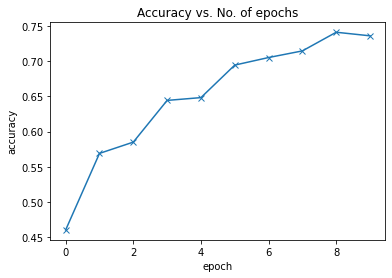

In [ ]:
plot_accuracies(history)

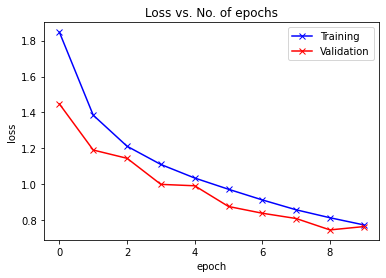

In [ ]:
plot_losses(history)

دقت این مدل روی ولید 73 درصد است .که نسبت به حالت 5 لایه کانولوشنالی کمی کمتر شده است.
حال دقت روی دیتای تست را نیز به دست می آوریم

In [ ]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 0.7696825265884399, 'val_acc': 0.736328125}

In [ ]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [ ]:
model2 = to_device(Cifar10CnnModel4layers(), device)

In [ ]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [ ]:
evaluate(model2, test_loader)

{'val_loss': 0.7696825265884399, 'val_acc': 0.736328125}

حال با سه لایه کانولوشنالی بررسی میکنیم

In [ ]:
class Cifar10CnnModel3layers(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.5),   

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.5),

            nn.Flatten(), 
            nn.Linear(128*8*8, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = Cifar10CnnModel3layers()
model

Cifar10CnnModel3layers(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.5, inplace=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=8192, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
model = to_device(Cifar10CnnModel3layers(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.302746057510376, 'val_acc': 0.11991038173437119}

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6687, val_loss: 1.3000, val_acc: 0.5343
Epoch [1], train_loss: 1.2290, val_loss: 1.0985, val_acc: 0.6146
Epoch [2], train_loss: 1.0536, val_loss: 0.9367, val_acc: 0.6659
Epoch [3], train_loss: 0.9323, val_loss: 0.8480, val_acc: 0.7032
Epoch [4], train_loss: 0.8463, val_loss: 0.7971, val_acc: 0.7207


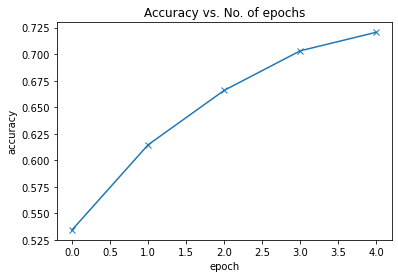

In [ ]:
plot_accuracies(history)

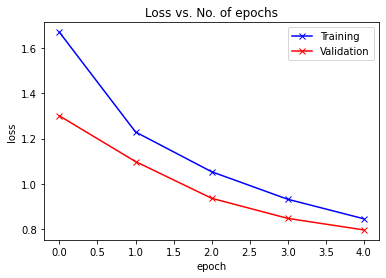

In [ ]:
plot_losses(history)

دقت در این مدل به 72 درصد روی مجموعه ی ولید رسید که از قبلی ها کمتر است.البته میتواند مربوط به کاهش اپوک هم باشد ولی چون با تعداد اپوک بالاتر دچار اورفیت میشدیم مجبور به کاهش آن گشتیم

پس گویی کاهش تعداد لایه های کانولوشنالی سبب کاهش دقتمان شد

 استفاده کنیم و نتایج را مشاهده کنیمbatch normalization حالا بیایم از 



In [ ]:
class CnnBatch(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.5),   

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Dropout(0.5),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model =CnnBatch()
model

CnnBatch(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inpl

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [ ]:
model = to_device(CnnBatch(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 2.3029754161834717, 'val_acc': 0.10143611580133438}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6452, val_loss: 0.6344, val_acc: 0.7854
Epoch [1], train_loss: 0.5936, val_loss: 0.7668, val_acc: 0.7481
Epoch [2], train_loss: 0.5629, val_loss: 0.6013, val_acc: 0.8021
Epoch [3], train_loss: 0.5282, val_loss: 0.5697, val_acc: 0.8104
Epoch [4], train_loss: 0.4939, val_loss: 0.5702, val_acc: 0.8160
Epoch [5], train_loss: 0.4604, val_loss: 0.5445, val_acc: 0.8250
Epoch [6], train_loss: 0.4438, val_loss: 0.5367, val_acc: 0.8199
Epoch [7], train_loss: 0.4214, val_loss: 0.5025, val_acc: 0.8366
Epoch [8], train_loss: 0.4014, val_loss: 0.5441, val_acc: 0.8279
Epoch [9], train_loss: 0.3799, val_loss: 0.5319, val_acc: 0.8311


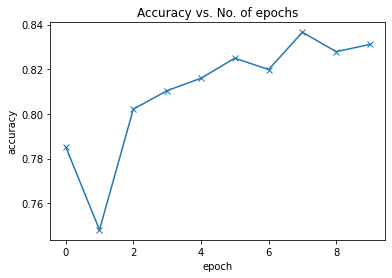

In [ ]:
plot_accuracies(history)

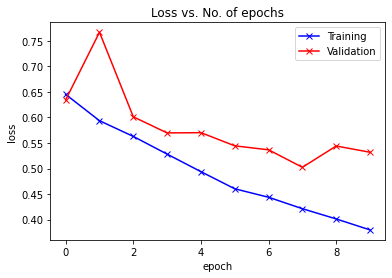

In [ ]:
plot_losses(history)

مشاهده میشود بعد از اپوک 3 دچار اورفیت میشویم ولی اگر در همانجاهم متوقف کنیم دقت مدلمان افزایش یافته و به 81 درصد میرسد

حال کمی تغییرات بر روی شبکه ایجاد میکنیم و نتایج را نظاره میکنیم

 
  استفاده میکنیمtanh هست از relue مان که actfuncبه جای 

In [29]:
class CnnBatch(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.5),   

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Dropout(0.5),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [30]:
model =CnnBatch()
model

CnnBatch(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Tanh()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Tanh()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Tanh()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inpl

In [35]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [36]:
model = to_device(CnnBatch(), device)

In [39]:
evaluate(model, val_dl)

{'val_loss': 2.303177833557129, 'val_acc': 0.0963350161910057}

In [42]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [43]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6991, val_loss: 1.5170, val_acc: 0.4458
Epoch [1], train_loss: 1.3061, val_loss: 1.2123, val_acc: 0.5612
Epoch [2], train_loss: 1.1285, val_loss: 1.0126, val_acc: 0.6376
Epoch [3], train_loss: 1.0162, val_loss: 0.9501, val_acc: 0.6658
Epoch [4], train_loss: 0.9304, val_loss: 0.9493, val_acc: 0.6617
Epoch [5], train_loss: 0.8778, val_loss: 0.9032, val_acc: 0.6799
Epoch [6], train_loss: 0.8190, val_loss: 0.8861, val_acc: 0.6868
Epoch [7], train_loss: 0.7692, val_loss: 0.8504, val_acc: 0.7127
Epoch [8], train_loss: 0.7265, val_loss: 0.7534, val_acc: 0.7420
Epoch [9], train_loss: 0.6920, val_loss: 0.7612, val_acc: 0.7387


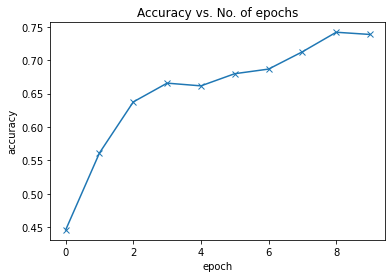

In [44]:
plot_accuracies(history)

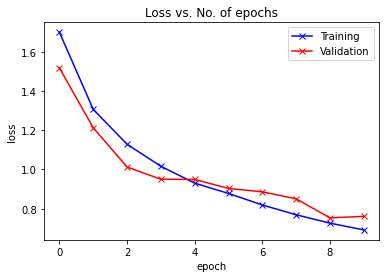

In [45]:
plot_losses(history)

همانطور که دیده میشود دقت با این کار افت میکند::

بیایم یکم با لرنینگ ریت بازی کنیم

In [46]:
class CnnBatch(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.Dropout(0.5),   

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.Dropout(0.5),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.Dropout(0.5),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [47]:
model =CnnBatch()
model

CnnBatch(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Dropout(p=0.5, inpl

In [55]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [56]:
model = to_device(CnnBatch(), device)

In [57]:
evaluate(model, val_dl)

{'val_loss': 2.303375244140625, 'val_acc': 0.0963350161910057}

In [58]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.0001

In [59]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.6184, val_loss: 2.3159, val_acc: 0.3004
Epoch [1], train_loss: 1.2682, val_loss: 2.2643, val_acc: 0.3560
Epoch [2], train_loss: 1.0965, val_loss: 1.8957, val_acc: 0.4297
Epoch [3], train_loss: 0.9752, val_loss: 1.1902, val_acc: 0.5945
Epoch [4], train_loss: 0.8949, val_loss: 1.0409, val_acc: 0.6312
Epoch [5], train_loss: 0.8277, val_loss: 1.0997, val_acc: 0.6274
Epoch [6], train_loss: 0.7701, val_loss: 0.8737, val_acc: 0.6984
Epoch [7], train_loss: 0.7187, val_loss: 0.8426, val_acc: 0.7121
Epoch [8], train_loss: 0.6797, val_loss: 0.7589, val_acc: 0.7358
Epoch [9], train_loss: 0.6471, val_loss: 0.7863, val_acc: 0.7302


In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)